![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/27.1.Oncology_Use_Cases.ipynb)

## Healthcare NLP for Data Scientists Course

If you are not familiar with the components in this notebook, you can check [Healthcare NLP for Data Scientists Udemy Course](https://www.udemy.com/course/healthcare-nlp-for-data-scientists/) and the [MOOC Notebooks](https://github.com/JohnSnowLabs/spark-nlp-workshop/tree/master/Spark_NLP_Udemy_MOOC/Healthcare_NLP) for each components.

## ⚒️ Setup

In [ ]:
import json
import os

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

locals().update(license_keys)

os.environ.update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.4.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [3]:
import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp_jsl.pretrained import InternalResourceDownloader

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel

import pandas as pd
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

spark

Spark NLP Version : 5.5.1
Spark NLP_JSL Version : 5.5.1


# Clinical Story: Processing Oncology Notes with Metastasis

In a bustling oncology research center, a team of data scientists and clinicians collaborates to unravel the complexities of cancer progression. Their focus today: the challenging and intricate process of metastasis — the spread of cancer from its original site to other parts of the body. They aim to leverage advanced computational tools to uncover meaningful insights and better understand the nuances of metastatic disease.

## 📌 List of Pretrained Oncology Models

In [4]:
import pandas as pd

df = pd.DataFrame()
for model_type in ['MedicalNerModel', 'RelationExtractionModel', 'RelationExtractionDLModel',
                   'AssertionDLModel', 'MedicalBertForSequenceClassification']:

    model_list = [model[0] for model in InternalResourceDownloader.returnPrivateModels(model_type)
                  if ("oncology" in model[0]) or ("cancer" in model[0]) or ("biomarker" in model[0]) or ("response" in model[0])]
    #model_list = [model_name.replace("_wip","") for model_name in model_list]
    model_list = [model_name for model_name in model_list if "wip" not in model_name]
    model_list = sorted(set(model_list))
    df = pd.concat([df, pd.DataFrame(model_list, columns = [model_type])], axis = 1)

df.fillna('')

,MedicalNerModel,RelationExtractionModel,RelationExtractionDLModel,AssertionDLModel,MedicalBertForSequenceClassification
0,ner_biomarker,re_oncology,redl_oncology_biobert,assertion_oncology,bert_sequence_classifier_biomarker
1,ner_biomarker_langtest,re_oncology_biomarker_result,redl_oncology_biomarker_result_biobert,assertion_oncology_demographic_binary,bert_sequence_classifier_response_to_treatment
2,ner_cancer_genetics,re_oncology_granular,redl_oncology_granular_biobert,assertion_oncology_family_history,
3,ner_cancer_types,re_oncology_location,redl_oncology_location_biobert,assertion_oncology_problem,
4,ner_oncology,re_oncology_size,redl_oncology_size_biobert,assertion_oncology_response_to_treatment,
5,ner_oncology_anatomy_general,re_oncology_temporal,redl_oncology_temporal_biobert,assertion_oncology_smoking_status,
6,ner_oncology_anatomy_general_healthcare,re_oncology_test_result,redl_oncology_test_result_biobert,assertion_oncology_test_binary,
7,ner_oncology_anatomy_general_langtest,,,assertion_oncology_treatment_binary,
8,ner_oncology_anatomy_granular,,,,
9,ner_oncology_anatomy_granular_langtest,,,,


**Medidical NER Models and labels**

<br>


**labels**                 | **description**                                                                                                                                                                                                                        | **ner_oncology** | **ner_oncology_anatomy_general** | **ner_oncology_anatomy_general_healthcare** | **ner_oncology_anatomy_granular** | **ner_oncology_biomarker** | **ner_oncology_biomarker_healthcare** | **ner_oncology_demographics** | **ner_oncology_diagnosis** | **ner_oncology_emb_clinical_large** | **ner_oncology_emb_clinical_medium** | **ner_oncology_limited_80p_for_benchmarks** | **ner_oncology_posology** | **ner_oncology_response_to_treatment** | **ner_oncology_test** | **ner_oncology_therapy** | **ner_oncology_tnm** | **ner_oncology_unspecific_posology** | **ner_oncology_unspecific_posology_healthcare**
:-------------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:----------------:|:--------------------------------:|:-------------------------------------------:|:---------------------------------:|:--------------------------:|:-------------------------------------:|:-----------------------------:|:--------------------------:|:-----------------------------------:|:------------------------------------:|:-------------------------------------------:|:-------------------------:|:--------------------------------------:|:---------------------:|:------------------------:|:--------------------:|:------------------------------------:|:-----------------------------------------------:
 **Adenopathy**            | Mentions of pathological findings of the lymph nodes.                                                                                                                                                                                  | X                |                                  |                                             |                                   |                            |                                       |                               | X                          | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Age**                   | All mention of ages, past or present, related to the patient or with anybody else.                                                                                                                                                     | X                |                                  |                                             |                                   |                            |                                       | X                             |                            | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Biomarker**             | Biological molecules that indicate the presence or absence of cancer, or the type of cancer. Oncogenes are excluded from this category.                                                                                                | X                |                                  |                                             |                                   | X                          | X                                     |                               |                            | X                                   | X                                    | X                                           |                           |                                        | X                     |                          |                      |                                      |                                                 
 **Biomarker_Result**      | Terms or values that are identified as the result of a biomarkers.                                                                                                                                                                     | X                |                                  |                                             |                                   | X                          | X                                     |                               |                            | X                                   | X                                    | X                                           |                           |                                        | X                     |                          |                      |                                      |                                                 
 **Cancer_Dx**             | Mentions of cancer diagnoses (such as “breast cancer”) or pathological types that are usually used as synonyms for “cancer” (e.g. “carcinoma”). <br> When anatomical references are present, they are included in the Cancer_Dx extraction. | X                |                                  |                                             |                                   |                            |                                       |                               | X                          | X                                   | X                                    | X                                           |                           |                                        |                       |                          | X                    |                                      |                                                 
 **Cancer_Score**          | Clinical or imaging scores that are specific for cancer settings (e.g. “BI-RADS” or “Allred score”).                                                                                                                                   | X                |                                  |                                             |                                   |                            |                                       |                               | X                          | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Cancer_Surgery**        | Terms that indicate surgery as a form of cancer treatment.                                                                                                                                                                             | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           | X                         |                                        |                       | X                        |                      |                                      |                                                 
 **Chemotherapy**          | Mentions of chemotherapy drugs, or unspecific words such as “chemotherapy”.                                                                                                                                                            | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           |                                        |                       | X                        |                      |                                      |                                                 
 **Cycle_Count**           | The total number of cycles being administered of an oncological therapy (e.g. “5 cycles”).                                                                                                                                             | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           | X                         |                                        |                       | X                        |                      |                                      |                                                 
 **Cycle_Day**             | References to the day of the cycle of oncological therapy (e.g. “day 5”).                                                                                                                                                              | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           | X                         |                                        |                       | X                        |                      |                                      |                                                 
 **Cycle_Number**          | The number of the cycle of an oncological therapy that is being applied (e.g. “third cycle”).                                                                                                                                          | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           | X                         |                                        |                       | X                        |                      |                                      |                                                 
 **Date**                  | Mentions of exact dates, in any format, including day number, month and/or year.                                                                                                                                                       | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Death_Entity**          | Words that indicate the death of the patient or someone else (including family members), such as “died” or “passed away”.                                                                                                              | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Direction**             | Directional and laterality terms, such as “left”, “right”, “bilateral”, “upper” and “lower”.                                                                                                                                           | X                | X                                | X                                           | X                                 |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Dosage**                | The quantity prescribed by the physician for an active ingredient.                                                                                                                                                                     | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           | X                         |                                        |                       | X                        |                      |                                      |                                                 
 **Duration**              | Words indicating the duration of a treatment (e.g. “for 2 weeks”).                                                                                                                                                                     | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           | X                         |                                        |                       | X                        |                      |                                      |                                                 
 **Frequency**             | Words indicating the frequency of treatment administration (e.g. “daily” or “bid”).                                                                                                                                                    | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           | X                         |                                        |                       | X                        |                      |                                      |                                                 
 **Gender**                | Gender-specific nouns and pronouns (including words such as “him” or “she”, and family members such as “father”).                                                                                                                      | X                |                                  |                                             |                                   |                            |                                       | X                             |                            | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Grade**                 | All pathological grading of tumors (e.g. “grade 1”) or degrees of cellular differentiation (e.g. “well-differentiated”)                                                                                                                | X                |                                  |                                             |                                   |                            |                                       |                               | X                          | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Histological_Type**     | Histological variants or cancer subtypes, such as “papillary”, “clear cell” or “medullary”.                                                                                                                                            | X                |                                  |                                             |                                   |                            |                                       |                               | X                          | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Hormonal_Therapy**      | Mentions of hormonal drugs used to treat cancer, or unspecific words such as “hormonal therapy”.                                                                                                                                       | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           |                                        |                       | X                        |                      |                                      |                                                 
 **Imaging_Test**          | Imaging tests mentioned in texts, such as “chest CT scan”.                                                                                                                                                                             | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           |                                        | X                     |                          |                      |                                      |                                                 
 **Immunotherapy**         | Mentions of immunotherapy drugs, or unspecific words such as “immunotherapy”.                                                                                                                                                          | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           |                                        |                       | X                        |                      |                                      |                                                 
 **Invasion**              | Mentions that refer to tumor invasion, such as “invasion” or “involvement”. Metastases or lymph node involvement are excluded from this category.                                                                                      | X                |                                  |                                             |                                   |                            |                                       |                               | X                          | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Line_Of_Therapy**       | Explicit references to the line of therapy of an oncological therapy (e.g. “first-line treatment”).                                                                                                                                    | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           | X                                      |                       | X                        |                      |                                      |                                                 
 **Metastasis**            | Terms that indicate a metastatic disease. Anatomical references are not included in these extractions.                                                                                                                                 | X                |                                  |                                             |                                   |                            |                                       |                               | X                          | X                                   | X                                    | X                                           |                           |                                        |                       |                          | X                    |                                      |                                                 
 **Oncogene**              | Mentions of genes that are implicated in the etiology of cancer.                                                                                                                                                                       | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           |                                        | X                     |                          |                      |                                      |                                                 
 **Pathology_Result**      | The findings of a biopsy from the pathology report that is not covered by another entity (e.g. “malignant ductal cells”).                                                                                                              | X                |                                  |                                             |                                   |                            |                                       |                               | X                          | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Pathology_Test**        | Mentions of biopsies or tests that use tissue samples.                                                                                                                                                                                 | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           |                                        | X                     |                          |                      |                                      |                                                 
 **Performance_Status**    | Mentions of performance status scores, such as ECOG and Karnofsky. The name of the score is extracted together with the result (e.g. “ECOG performance status of 4”).                                                                  | X                |                                  |                                             |                                   |                            |                                       |                               | X                          | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Race_Ethnicity**        | The race and ethnicity categories include racial and national origin or sociocultural groups.                                                                                                                                          | X                |                                  |                                             |                                   |                            |                                       | X                             |                            | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Radiotherapy**          | Terms that indicate the use of Radiotherapy.                                                                                                                                                                                           | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           | X                         |                                        |                       | X                        |                      |                                      |                                                 
 **Response_To_Treatment** | Terms related to clinical progress of the patient related to cancer treatment, including “recurrence”, “bad response” or “improvement”.                                                                                                | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           | X                                      |                       | X                        |                      |                                      |                                                 
 **Relative_Date**         | Temporal references that are relative to the date of the text or to any other specific date (e.g. “yesterday” or “three years later”).                                                                                                 | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Route**                 | Words indicating the type of administration route (such as “PO” or “transdermal”).                                                                                                                                                     | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           | X                         |                                        |                       | X                        |                      |                                      |                                                 
 **Site_Bone**             | Anatomical terms that refer to the human skeleton.                                                                                                                                                                                     | X                |                                  |                                             | X                                 |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Site_Brain**            | Anatomical terms that refer to the central nervous system (including the brain stem and the cerebellum).                                                                                                                               | X                |                                  |                                             | X                                 |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Site_Breast**           | Anatomical terms that refer to the breasts.                                                                                                                                                                                            | X                |                                  |                                             | X                                 |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Site_Liver**            | Anatomical terms that refer to the liver.                                                                                                                                                                                              | X                |                                  |                                             | X                                 |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Site_Lung**             | Anatomical terms that refer to the lungs.                                                                                                                                                                                              | X                |                                  |                                             | X                                 |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Site_Lymph_Node**       | Anatomical terms that refer to lymph nodes, excluding adenopathies.                                                                                                                                                                    | X                |                                  |                                             | X                                 |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Site_Other_Body_Part**  | Relevant anatomical terms that are not included in the rest of the anatomical entities.                                                                                                                                                | X                |                                  |                                             | X                                 |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Smoking_Status**        | All mentions of smoking related to the patient or to someone else.                                                                                                                                                                     | X                |                                  |                                             |                                   |                            |                                       | X                             |                            | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Staging**               | Mentions of cancer stage such as “stage 2b” or “T2N1M0”. It also includes words such as “in situ”, “early-stage” or “advanced”.                                                                                                        | X                |                                  |                                             |                                   |                            |                                       |                               | X                          | X                                   | X                                    | X                                           |                           |                                        |                       |                          | X                    |                                      |                                                 
 **Targeted_Therapy**      | Mentions of targeted therapy drugs, or unspecific words such as “targeted therapy”.                                                                                                                                                    | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           |                                        |                       | X                        |                      |                                      |                                                 
 **Tumor_Finding**         | All nonspecific terms that may be related to tumors, either malignant or benign (for example: “mass”, “tumor”, “lesion”, or “neoplasm”).                                                                                               | X                |                                  |                                             |                                   |                            |                                       |                               | X                          | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Tumor_Size**            | Size of the tumor, including numerical value and unit of measurement (e.g. “3 cm”).                                                                                                                                                    | X                |                                  |                                             |                                   |                            |                                       |                               | X                          | X                                   | X                                    | X                                           |                           |                                        |                       |                          |                      |                                      |                                                 
 **Unspecific_Therapy**    | Terms that indicate a known cancer therapy but that is not specific to any other therapy entity (e.g. “chemoradiotherapy” or “adjuvant therapy”).                                                                                      | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           |                           |                                        |                       | X                        |                      |                                      |                                                 
 **Radiation_Dose**        | Dose used in radiotherapy.                                                                                                                                                                                                             | X                |                                  |                                             |                                   |                            |                                       |                               |                            | X                                   | X                                    | X                                           | X                         |                                        |                       | X                        |                      |                                      |                                                 
 **Anatomical_Site**       | Relevant anatomical terms mentioned in text.                                                                                                                                                                                           |                  | X                                | X                                           |                                   |                            |                                       |                               |                            |                                     |                                      |                                             |                           |                                        |                       |                          |                      |                                      |                                                 
 **Cancer_Therapy**        | Mentions of cancer treatments, including chemotherapy, radiotherapy, surgery and other.                                                                                                                                                |                  |                                  |                                             |                                   |                            |                                       |                               |                            |                                     |                                      |                                             | X                         |                                        |                       |                          |                      | X                                    | X                                               
 **Size_Trend**            | Terms related to the changes in the size of the tumor (such as “growth” or “reduced in size”).                                                                                                                                         |                  |                                  |                                             |                                   |                            |                                       |                               |                            |                                     |                                      |                                             |                           | X                                      |                       |                          |                      |                                      |                                                 
 **Lymph_Node**            | Mentions of lymph nodes and pathological findings of the lymph nodes.                                                                                                                                                                  |                  |                                  |                                             |                                   |                            |                                       |                               |                            |                                     |                                      |                                             |                           |                                        |                       |                          | X                    |                                      |                                                 
 **Tumor_Description**     | Information related to tumor characteristics, such as size, presence of invasion, grade and hystological type.                                                                                                                         |                  |                                  |                                             |                                   |                            |                                       |                               |                            |                                     |                                      |                                             |                           |                                        |                       |                          | X                    |                                      |                                                 
 **Tumor**                 | All nonspecific terms that may be related to tumors, either malignant or benign (for example: “mass”, “tumor”, “lesion”, or “neoplasm”).                                                                                               |                  |                                  |                                             |                                   |                            |                                       |                               |                            |                                     |                                      |                                             |                           |                                        |                       |                          | X                    |                                      |                                                 
 **Lymph_Node_Modifier**   | Words that refer to a lymph node being abnormal (such as “enlargement”).                                                                                                                                                               |                  |                                  |                                             |                                   |                            |                                       |                               |                            |                                     |                                      |                                             |                           |                                        |                       |                          | X                    |                                      |                                                 
 **Posology_Information**  | Terms related to the posology of the treatment, including duration, frequencies and dosage.                                                                                                                                            |                  |                                  |                                             |                                   |                            |                                       |                               |                            |                                     |                                      |                                             |                           |                                        |                       |                          |                      | X                                    | X                                               



## 📌 Dataset

We will use [MT ONCOLOGY NOTES](https://www.mtsamplereports.com/) comprises of millions of ehr records of patients. It contains semi-structured data like demographics, insurance details, and a lot more, but most importantly, it also contains free-text data like real encounters and notes. Here we show how to use Spark NLP's existing models to process raw text and extract highly specialized cancer information that can be used for various downstream use cases, including:

In [4]:
# Downloading sample datasets.
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/mt_samples_10_wo_keyword.csv

In [5]:
mt_samples_df = spark.read.csv("mt_samples_10_wo_keyword.csv", header=True, multiLine=True).withColumnRenamed("index", "patient_id")
mt_samples_df.show(truncate=150)

+----------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|patient_id|                                                                                                                                                  text|
+----------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|         0|Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nDischarge Summary - Mesothelioma - 1\nDescription:\nMesothelioma, pleural ef...|
|         1|Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nBCCa Excision - Lower Lid\nDescription:\nExcision of large basal cell carcin...|
|         2|Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nAnemia - Consult\nDescription:\nRefractory anemia that is transfusion depend...|
|         3|Samp

In [6]:
sample_text = mt_samples_df.limit(1).collect()[0]['text']
print(sample_text)

Sample Type / Medical Specialty:
Hematology - Oncology
Sample Name:
Discharge Summary - Mesothelioma - 1
Description:
Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
(Medical Transcription Sample Report)
PRINCIPAL DIAGNOSIS:
Mesothelioma.
SECONDARY DIAGNOSES:
Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
PROCEDURES
1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy.
2. On August 20, 2007, thoracentesis.
3. On August 31, 2007, Port-A-Cath placement.
HISTORY AND PHYSICAL:
The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care cen

## 📌 Problem Solving

### 📍 1.Step: Entity Extraction

🎊  We will create a robust NER pipeline to extract oncological entities and body parts.



#### 📍 Pretrained Oncology NER Profiling Pipeline

We can use pretrained NER profiling pipelines for exploring all the available pretrained NER models at once.

- `ner_profiling_oncology` : Returns results for oncology NER models.

For more examples, please check [this notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/11.2.Pretrained_NER_Profiling_Pipelines.ipynb).

<center><b>NER Profiling Oncology Model List</b>

|| | | |
|--------------|-----------------|-----------------|-----------------|
| ner_oncology_unspecific_posology | ner_oncology_tnm | ner_oncology_therapy | ner_oncology_test |
| ner_oncology_response_to_treatment | ner_oncology_posology | ner_oncology | ner_oncology_limited_80p_for_benchmarks |
| ner_oncology_diagnosis | ner_oncology_demographics | ner_oncology_biomarker | ner_oncology_anatomy_granular | ner_oncology_anatomy_general |



</center>

In [ ]:
from sparknlp.pretrained import PretrainedPipeline

oncology_profiling_pipeline = PretrainedPipeline("ner_profiling_oncology", "en", "clinical/models")

ner_profiling_oncology download started this may take some time.
Approx size to download 2.2 GB
[OK!]


In [ ]:
oncology_result = oncology_profiling_pipeline.fullAnnotate(sample_text)[0]
oncology_result.keys()

dict_keys(['oncology_anatomy_general_ner', 'oncology_anatomy_granular_ner', 'oncology_diagnosis_langtest_ner', 'oncology_anatomy_general_langtest_ner', 'oncology_langtest_ner', 'oncology_anatomy_granular_langtest_ner', 'ner_chunk_jsl_greedy', 'ner_chunk_jsl_enriched', 'oncology_ner', 'oncology_tnm_ner', 'ner_chunk_oncology_anatomy_general', 'document', 'ner_chunk_oncology_test', 'ner_chunk_jsl_slim', 'ner_chunk_oncology_posology_langtest', 'jsl_langtest_ner', 'oncology_test_langtest_ner', 'jsl_greedy_ner', 'oncology_biomarker_langtest_ner', 'ner_chunk_oncology_biomarker_langtest', 'ner_chunk_oncology_limited_80p_for_benchmarks_ner', 'oncology_tnm_langtest_ner', 'ner_chunk_oncology_tnm', 'ner_chunk_oncology', 'jsl_enriched_ner', 'oncology_response_to_treatment_langtest_ner', 'ner_chunk_oncology_therapy', 'ner_chunk_jsl', 'oncology_limited_80p_for_benchmarks_ner', 'oncology_therapy_ner', 'ner_chunk_oncology_therapy_langtest', 'ner_chunk_oncology_response_to_treatment_langtest_ner', 'ner_

In [ ]:
import pandas as pd

def get_token_results(light_result):

    tokens = [j.result for j in light_result["token"]]
    sentences = [j.metadata["sentence"] for j in light_result["token"]]
    begins = [j.begin for j in light_result["token"]]
    ends = [j.end for j in light_result["token"]]
    model_list = [ a for a in light_result.keys() if (a not in ["document", "embeddings", "sentence", "token"] and "_chunk" not in a)]

    df = pd.DataFrame({'sentence':sentences, 'begin': begins, 'end': ends, 'token':tokens})

    for model_name in model_list:

        temp_df = pd.DataFrame(light_result[model_name])
        temp_df["jsl_label"] = temp_df.iloc[:,0].apply(lambda x : x.result)
        temp_df = temp_df[["jsl_label"]]

        # temp_df = get_ner_result(model_name)
        temp_df.columns = [model_name]
        df = pd.concat([df, temp_df], axis=1)

    # Filter columns to include only sentence, begin, end, token and all columns that start with 'ner_vop'
    filtered_df = df.loc[:, ['sentence', 'begin', 'end', 'token'] + [col for col in df.columns if col.startswith('oncology')]]

    return filtered_df

In [ ]:
get_token_results(oncology_result)

,sentence,begin,end,token,oncology_anatomy_general_ner,oncology_anatomy_granular_ner,oncology_diagnosis_langtest_ner,oncology_anatomy_general_langtest_ner,oncology_langtest_ner,oncology_anatomy_granular_langtest_ner,...,oncology_unspecific_posology_langtest_ner,oncology_response_to_treatment_ner,oncology_posology_langtest_ner,oncology_demographics_ner,oncology_biomarker_ner,oncology_unspecific_posology_ner,oncology_test_ner,oncology_therapy_langtest_ner,oncology_diagnosis_ner,oncology_demographics_langtest_ner
0,0,0,5,Sample,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
1,0,7,10,Type,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
2,0,12,12,/,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
3,0,14,20,Medical,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
4,0,22,30,Specialty,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,78,5143,5150,concerns,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
959,78,5152,5153,in,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
960,78,5155,5157,the,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
961,78,5159,5165,interim,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


#### 📍 NER Pipeline


🔖 The NER models from the list include different entity groups and levels of granularity. We can extract as much information as possible from oncology texts using `ner_oncology` model which is the most granular model. But we will add some other NER models to create a robust pipeline in this stage and then we will merge the detected entities using `ChunkMergerApproach` to get a single chunk at the end.

In [ ]:
# Step 1: Transforms raw text to `document`type
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

# Step 2: Sentence Detection/Splitting
sentence_detector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

# Step 3: Tokenization
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")\

# Step 4: Clinical Embeddings
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings")

# Step 5: NER Model
ner_cancer_types = MedicalNerModel.pretrained("ner_cancer_types_wip", "en", "clinical/models") \
    .setInputCols(["sentence","token", "embeddings"]) \
    .setOutputCol("cancer_types_ner")

# Step 6: Converter
ner_cancer_types_converter = NerConverterInternal() \
    .setInputCols(["sentence","token","cancer_types_ner"]) \
    .setOutputCol("cancer_types_chunk")\
    .setReplaceLabels({"Body_Site": "Anatomical_Site"})

# Step 7 Filterer to get only the texts of ineterst for the use case
filterer = DocumentFiltererByNER() \
    .setInputCols(["sentence", "cancer_types_chunk"]) \
    .setOutputCol("filterer") \
    .setWhiteList(["Metastasis"])

#, "Leukemia_Type", "Lymphoma_Type", "Sarcoma_Type", "Melanoma", "CNS_Tumor_Type"

# Define the pipeline
nlp_pipeline = Pipeline(stages=[
        document_assembler,
        sentence_detector,
        tokenizer,
        word_embeddings,
        ner_cancer_types,
        ner_cancer_types_converter,
        filterer
        ])

# Create an empty dataframe
data = spark.createDataFrame([[""]]).toDF("text")

# Fit the dataframe to the pipeline to get the model
nlp_model = nlp_pipeline.fit(data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_cancer_types_wip download started this may take some time.
[OK!]


In [ ]:
result = nlp_model.transform(mt_samples_df)
result.show()

+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|patient_id|                text|            document|            sentence|               token|          embeddings|    cancer_types_ner|  cancer_types_chunk|            filterer|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         0|Sample Type / Med...|[{document, 0, 51...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 132, 138...|                  []|
|         1|Sample Type / Med...|[{document, 0, 29...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 90, 92, ...|                  []|
|         2|Sample Type / Med...|[{document, 0, 40...|[{document, 0, 53...|[{token, 0, 5, Sa...

In [ ]:
from pyspark.sql.functions import col, explode, collect_set

# Explode the metadata array to create one row per metadata entry
metadata_exploded = result.select("patient_id", explode(col("cancer_types_chunk.metadata")).alias("metadata_entry"))

# Extract the "entity" field from each metadata map
entities = metadata_exploded.select(
    col("patient_id"),
    col("metadata_entry").getItem("entity").alias("entity")
)

# Group by patient_id and collect all entities into a list
entities_grouped = entities.groupBy("patient_id").agg(
    collect_set("entity").alias("entity_labels")
)

# Show the results
entities_grouped.show(truncate=False)


+----------+------------------------------------------------------------------------+
|patient_id|entity_labels                                                           |
+----------+------------------------------------------------------------------------+
|7         |[Biomarker, CNS_Tumor_Type, Metastasis, Anatomical_Site, Carcinoma_Type]|
|8         |[Metastasis, Anatomical_Site, Carcinoma_Type]                           |
|0         |[Anatomical_Site, Carcinoma_Type]                                       |
|6         |[Anatomical_Site]                                                       |
|9         |[Anatomical_Site, Carcinoma_Type]                                       |
|1         |[Anatomical_Site, Carcinoma_Type]                                       |
|4         |[Metastasis, Anatomical_Site, Carcinoma_Type]                           |
|2         |[Biomarker, Anatomical_Site]                                            |
+----------+------------------------------------------

In [ ]:
from pyspark.sql.functions import size

# Filter rows where the 'filtered' column is not an empty list
filtered_df = result.filter(size(result["filterer"]) > 0).select("patient_id", "text", "document", "sentence", "token", "embeddings", "cancer_types_chunk")

# Show the result
filtered_df.show()

+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|patient_id|                text|            document|            sentence|               token|          embeddings|  cancer_types_chunk|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         4|Sample Type / Med...|[{document, 0, 32...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{chunk, 68, 71, ...|
|         7|Sample Type / Med...|[{document, 0, 92...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{chunk, 68, 77, ...|
|         8|Sample Type / Med...|[{document, 0, 18...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{chunk, 68, 73, ...|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+



In [ ]:
# ner_oncology
ner_oncology = MedicalNerModel.pretrained("ner_oncology","en","clinical/models")\
    .setInputCols(["sentence","token","embeddings"])\
    .setOutputCol("ner_oncology")

ner_oncology_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","ner_oncology"])\
    .setOutputCol("ner_oncology_chunk")\
    .setWhiteList([ 'Adenopathy',
                    'Cancer_Dx',
                    'Histological_Type',
                    'Metastasis',
                    'Site_Bone',
                    'Site_Brain',
                    'Site_Breast',
                    'Site_Liver',
                    'Site_Lung',
                    'Site_Lymph_Node',
                    'Site_Other_Body_Part',
                    'Tumor_Finding'
                ])\
    .setReplaceLabels({"Site_Bone": "Anatomical_Site",
                       "Site_Brain": "Anatomical_Site",
                       "Site_Breast": "Anatomical_Site",
                       "Site_Liver": "Anatomical_Site",
                       "Site_Lung": "Anatomical_Site",
                       "Site_Lymph_Node": "Anatomical_Site",
                       "Site_Other_Body_Part": "Anatomical_Site"
                      })

# ner_oncology_anatomy_general
ner_oncology_anatomy = MedicalNerModel.pretrained("ner_oncology_anatomy_general","en","clinical/models")\
    .setInputCols(["sentence","token","embeddings"])\
    .setOutputCol("ner_oncology_anatomy")

ner_oncology_anatomy_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","ner_oncology_anatomy"])\
    .setOutputCol("ner_oncology_anatomy_chunk")\
    .setWhiteList(["Anatomical_Site"])

# ner_jsl
jsl_ner = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("jsl_ner")

jsl_ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "jsl_ner"]) \
    .setOutputCol("jsl_ner_chunk")\
    .setWhiteList(["Oncological", "Internal_organ_or_component", "External_body_part_or_region"])\
    .setReplaceLabels({"External_body_part_or_region": "Anatomical_Site",
                       "Internal_organ_or_component": "Anatomical_Site"})

chunk_merger = ChunkMergeApproach()\
    .setInputCols(["cancer_types_chunk", "ner_oncology_chunk", "ner_oncology_anatomy_chunk", "jsl_ner_chunk"])\
    .setOutputCol("merged_ner_chunk")

chunk_filterer = ChunkFilterer()\
    .setInputCols("sentence", "merged_ner_chunk")\
    .setOutputCol("ner_chunk") \
    .setCriteria("isin") \
    .setBlackList(["HEENT"])

ner_stages = [
    document_assembler,
    sentence_detector,
    tokenizer,
    word_embeddings,
    ner_oncology,
    ner_oncology_converter,
    ner_oncology_anatomy,
    ner_oncology_anatomy_converter,
    jsl_ner,
    jsl_ner_converter,
    chunk_merger,
    chunk_filterer
]

ner_pipeline = Pipeline(stages=ner_stages)

empty_data = spark.createDataFrame([[""]]).toDF("text")
ner_model = ner_pipeline.fit(empty_data)

ner_oncology download started this may take some time.
[OK!]
ner_oncology_anatomy_general download started this may take some time.
[OK!]
ner_jsl download started this may take some time.
[OK!]


In [ ]:
ner_oncology_labels = sorted(list(set([label.split('-')[-1] for label in ner_oncology.getClasses() if label != 'O'])))

len(ner_oncology_labels)

49

In [ ]:
label_df = pd.DataFrame()
for column in range((len(ner_oncology_labels)//10)+1):
  label_df = pd.concat([label_df, pd.DataFrame(ner_oncology_labels, columns = [''])[column*10:(column+1)*10].reset_index(drop= True)], axis = 1)

label_df.fillna('')

,,,,,
0,Adenopathy,Cycle_Number,Hormonal_Therapy,Race_Ethnicity,Site_Lung
1,Age,Date,Imaging_Test,Radiation_Dose,Site_Lymph_Node
2,Biomarker,Death_Entity,Immunotherapy,Radiotherapy,Site_Other_Body_Part
3,Biomarker_Result,Direction,Invasion,Relative_Date,Smoking_Status
4,Cancer_Dx,Dosage,Line_Of_Therapy,Response_To_Treatment,Staging
5,Cancer_Score,Duration,Metastasis,Route,Targeted_Therapy
6,Cancer_Surgery,Frequency,Oncogene,Site_Bone,Tumor_Finding
7,Chemotherapy,Gender,Pathology_Result,Site_Brain,Tumor_Size
8,Cycle_Count,Grade,Pathology_Test,Site_Breast,Unspecific_Therapy
9,Cycle_Day,Histological_Type,Performance_Status,Site_Liver,


In [ ]:
ner_results = ner_model.transform(filtered_df).cache()
ner_results.show(3)

+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+
|patient_id|                text|            document|            sentence|               token|          embeddings|  cancer_types_chunk|        ner_oncology|  ner_oncology_chunk|ner_oncology_anatomy|ner_oncology_anatomy_chunk|             jsl_ner|       jsl_ner_chunk|    merged_ner_chunk|           ner_chunk|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+
|         4|Sample Type / Med...|[{document, 0, 32...|[{docum

In [ ]:
sample_result = ner_results.limit(1).collect()[0]
sample_result['ner_chunk']

[Row(annotatorType='chunk', begin=68, end=71, result='Neck', metadata={'sentence': '1', 'chunk': '0', 'ner_source': 'cancer_types_chunk', 'entity': 'Anatomical_Site', 'confidence': '0.9953'}, embeddings=[]),
 Row(annotatorType='chunk', begin=102, end=105, result='neck', metadata={'sentence': '2', 'chunk': '1', 'ner_source': 'cancer_types_chunk', 'entity': 'Anatomical_Site', 'confidence': '0.9973'}, embeddings=[]),
 Row(annotatorType='chunk', begin=119, end=145, result='Metastatic papillary cancer', metadata={'sentence': '3', 'chunk': '2', 'ner_source': 'jsl_ner_chunk', 'entity': 'Oncological', 'confidence': '0.8552'}, embeddings=[]),
 Row(annotatorType='chunk', begin=153, end=156, result='neck', metadata={'sentence': '3', 'chunk': '3', 'ner_source': 'cancer_types_chunk', 'entity': 'Anatomical_Site', 'confidence': '0.9971'}, embeddings=[]),
 Row(annotatorType='chunk', begin=175, end=188, result='thyroid cancer', metadata={'sentence': '4', 'chunk': '4', 'ner_source': 'ner_oncology_chunk'

In [ ]:
from google.colab import widgets
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

t = widgets.TabBar(["cancer_types_chunk", "ner_oncology", "ner_oncology_anatomy", "ner_jsl", "ner_chunk"])

with t.output_to(0):
    visualiser.display(sample_result, label_col='cancer_types_chunk')

with t.output_to(1):
    visualiser.display(sample_result, label_col='ner_oncology_chunk')

with t.output_to(2):
    visualiser.display(sample_result, label_col='ner_oncology_anatomy_chunk')

with t.output_to(3):
    visualiser.display(sample_result, label_col='jsl_ner_chunk')

with t.output_to(4):
    visualiser.display(sample_result, label_col='ner_chunk')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🎈  **Save NER Results**

We should store the results as a backup in case there are errors during the spark session.

In [ ]:
ner_results.write.mode("overwrite").parquet("ner_results.parquet")

### 📍 2.Step: Assertion Status Detection

🎯  The NER models identified some entities, but these entities were either flagged as "not relevant to the patient" or "related to the patient's family" within the clinical notes. Therefore, we'll need to verify their assertion status and exclude any entities that don't directly pertain to the patient or they are not exist now.

🎯  For the assertion status detection pipeline, we will use the NER pipeline results and transform it on the assertion pipeline. Since already have the necessary columns in the NER results we can transform this results with assertion pipeline that we will create using [`assertion_oncology`](https://nlp.johnsnowlabs.com/2024/07/03/assertion_oncology_en.html) model. We will filter the assertion status of only the oncological entities and exclude `Anatomical_Site` ones using `ChunkFilterer` annotator. Then we will filter the `Present` entities using `AssertionFilterer` annotator.  Also you can use any assertion models that works well in your pipeline and merge their results using `AssertionMerger` annotator as we did for the NER.


In [ ]:
"""
assertion_chunk_merger = medical.ChunkMergeApproach()\
    .setInputCols(["ner_oncology_chunk", "jsl_ner_chunk"])\
    .setOutputCol("assertion_chunk")\
    .setWhiteList([ 'Adenopathy',
                    'Cancer_Dx',
                    'Death_Entity',
                    'Histological_Type',
                    'Metastasis',
                    'Oncological',
                    'Tumor_Finding',
                ])
"""

assertion_chunk_filterer = ChunkFilterer()\
    .setInputCols("sentence","ner_chunk")\
    .setOutputCol("assertion_chunk")\
    .setFilterEntity("entity")\
    .setBlackList(['Anatomical_Site'])

assertion_oncology = AssertionDLModel.pretrained("assertion_oncology", "en", "clinical/models") \
    .setInputCols(["sentence", 'assertion_chunk', "embeddings"]) \
    .setOutputCol("assertion")

assertion_filterer = AssertionFilterer()\
    .setInputCols("sentence","assertion_chunk","assertion")\
    .setOutputCol("assertion_filtered")\
    .setCaseSensitive(False)\
    .setWhiteList(["Present"])

assertion_pipeline_model = PipelineModel(stages=[
    assertion_chunk_filterer,
    assertion_oncology,
    assertion_filterer
    ])

assertion_oncology download started this may take some time.
[OK!]


In [ ]:
assertion_results = assertion_pipeline_model.transform(ner_results)
assertion_results.show(3)

+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|patient_id|                text|            document|            sentence|               token|          embeddings|  cancer_types_chunk|        ner_oncology|  ner_oncology_chunk|ner_oncology_anatomy|ner_oncology_anatomy_chunk|             jsl_ner|       jsl_ner_chunk|    merged_ner_chunk|           ner_chunk|     assertion_chunk|           assertion|  assertion_filtered|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------------+--------------------

In [ ]:
sample_assertion_result = assertion_results.limit(1).collect()[0]

In [ ]:
from sparknlp_display import AssertionVisualizer

vis = AssertionVisualizer()

vis.display(sample_assertion_result, 'assertion_filtered', 'assertion')

In [ ]:
sample_assertion_result.assertion_filtered

[Row(annotatorType='chunk', begin=119, end=145, result='Metastatic papillary cancer', metadata={'sentence': '3', 'chunk': '2', 'assertion': 'Present', 'ner_source': 'jsl_ner_chunk', 'entity': 'Oncological', 'confidence': '0.8552'}, embeddings=[]),
 Row(annotatorType='chunk', begin=175, end=188, result='thyroid cancer', metadata={'sentence': '4', 'chunk': '4', 'assertion': 'Present', 'ner_source': 'ner_oncology_chunk', 'entity': 'Cancer_Dx', 'confidence': '0.98305'}, embeddings=[]),
 Row(annotatorType='chunk', begin=191, end=204, result='papillary cell', metadata={'sentence': '4', 'chunk': '5', 'assertion': 'Present', 'ner_source': 'ner_oncology_chunk', 'entity': 'Histological_Type', 'confidence': '0.97315'}, embeddings=[]),
 Row(annotatorType='chunk', begin=393, end=419, result='Metastatic papillary cancer', metadata={'sentence': '6', 'chunk': '7', 'assertion': 'Present', 'ner_source': 'jsl_ner_chunk', 'entity': 'Oncological', 'confidence': '0.86590004'}, embeddings=[]),
 Row(annotator

In [ ]:
import pyspark.sql.functions as F

assertion_pd_df = assertion_results.select("patient_id", F.explode(F.arrays_zip(assertion_results.assertion_filtered.result,
                                                                                assertion_results.assertion_filtered.begin,
                                                                                assertion_results.assertion_filtered.end,
                                                                                assertion_results.assertion_filtered.metadata,
                                          )).alias("cols")) \
                                   .select("patient_id",
                                           F.expr("cols['3']['sentence']").alias("sent_id"),
                                           F.expr("cols['1']").alias("begin"),
                                           F.expr("cols['2']").alias("end"),
                                           F.expr("cols['0']").alias("chunk"),
                                           F.expr("cols['3']['entity']").alias("ner_label"),
                                           F.expr("cols['3']['assertion']").alias("assertion")
                                           ).toPandas()

assertion_pd_df

,patient_id,sent_id,begin,end,chunk,ner_label,assertion
0,4,3,119,145,Metastatic papillary cancer,Oncological,Present
1,4,4,175,188,thyroid cancer,Cancer_Dx,Present
2,4,4,191,204,papillary cell,Histological_Type,Present
3,4,6,393,419,Metastatic papillary cancer,Oncological,Present
4,4,7,458,484,Metastatic papillary cancer,Oncological,Present
5,4,9,638,651,thyroid cancer,Cancer_Dx,Present
6,4,9,654,667,papillary cell,Histological_Type,Present
7,4,10,817,822,lesion,Tumor_Finding,Present
8,7,3,166,190,metastatic ovarian cancer,Oncological,Present
9,7,5,256,280,Metastatic ovarian cancer,Oncological,Present


🎈 **Save Assertion Results**

In [ ]:
assertion_pd_df.to_csv("assertion_results.csv", index=False)

### 📍 3.Step: Relation Extraction

🎯 Certain code mappings achieve greater accuracy when they are more detailed. Therefore, we will examine the relationships between body parts and oncological entities. If a relationship exists, we will merge them to obtain their resolutions. This approach will improve mapping accuracy and enhance the precision of billing information.

🎊  *Example:*

- **cancer:** C80 - Malignant neoplasm without specification of site
- **lung cancer:** C34.9 - Malignant neoplasm of unspecified part of bronchus or lung

🩸 We will use the `ner_results` again and transform it on our relation extraction pipeline.

In [ ]:
ner_results.columns

['patient_id',
 'text',
 'document',
 'sentence',
 'token',
 'embeddings',
 'cancer_types_chunk',
 'ner_oncology',
 'ner_oncology_chunk',
 'ner_oncology_anatomy',
 'ner_oncology_anatomy_chunk',
 'jsl_ner',
 'jsl_ner_chunk',
 'merged_ner_chunk',
 'ner_chunk']

In [ ]:
pos_tagger = PerceptronModel.pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("pos_tags")

dependency_parser = DependencyParserModel.pretrained("dependency_conllu", "en") \
    .setInputCols(["sentence", "pos_tags", "token"]) \
    .setOutputCol("dependencies")

oncology_location_re = RelationExtractionModel.pretrained("re_oncology_location", "en", "clinical/models") \
    .setInputCols(["embeddings", "pos_tags", "ner_chunk", "dependencies"]) \
    .setOutputCol("relation_extraction") \
    .setRelationPairs(['Anatomical_Site-Adenopathy',
                       'Anatomical_Site-Cancer_Dx',
                       'Anatomical_Site-Histological_Type',
                       'Anatomical_Site-Metastasis',
                       'Anatomical_Site-Tumor_Finding',
                       'Anatomical_Site-Oncological',
                       'Anatomical_Site-CNS_Tumor_Type',
                       'Anatomical_Site-Carcinoma_Type'
                       ]) \
    .setMaxSyntacticDistance(10)

re_pipeline_model = PipelineModel(stages=[pos_tagger, dependency_parser, oncology_location_re])

pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]
re_oncology_location download started this may take some time.
[OK!]


In [ ]:
re_results = re_pipeline_model.transform(ner_results)
re_results.show(3)

+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|patient_id|                text|            document|            sentence|               token|          embeddings|  cancer_types_chunk|        ner_oncology|  ner_oncology_chunk|ner_oncology_anatomy|ner_oncology_anatomy_chunk|             jsl_ner|       jsl_ner_chunk|    merged_ner_chunk|           ner_chunk|            pos_tags|        dependencies| relation_extraction|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------------+--------------------

In [ ]:
sample_re_result = re_results.limit(3).collect()[2]
sample_re_result["relation_extraction"]

[Row(annotatorType='category', begin=379, end=437, result='O', metadata={'sentence': '6', 'entity1_begin': '379', 'chunk1': 'metastatic deposits', 'chunk2': 'chest wall', 'entity2_begin': '428', 'confidence': '0.87278074', 'entity2_end': '437', 'chunk2_confidence': '0.87409997', 'entity1': 'Oncological', 'entity2': 'Anatomical_Site', 'chunk1_confidence': '0.6421', 'entity1_end': '397', 'direction': 'both'}, embeddings=[]),
 Row(annotatorType='category', begin=379, end=469, result='O', metadata={'sentence': '6', 'entity1_begin': '379', 'chunk1': 'metastatic deposits', 'chunk2': 'neck lymph nodes', 'entity2_begin': '454', 'confidence': '0.7483868', 'entity2_end': '469', 'chunk2_confidence': '0.9777667', 'entity1': 'Oncological', 'entity2': 'Anatomical_Site', 'chunk1_confidence': '0.6421', 'entity1_end': '397', 'direction': 'both'}, embeddings=[]),
 Row(annotatorType='category', begin=1101, end=1149, result='is_location_of', metadata={'sentence': '20', 'entity1_begin': '1101', 'chunk1': '

In [ ]:
from sparknlp_display import RelationExtractionVisualizer


re_vis = RelationExtractionVisualizer()
re_vis.display(sample_re_result, 'relation_extraction', show_relations=True) # default show_relations: True

In [ ]:
from pyspark.sql import functions as F

re_result_pd_df = re_results.select("patient_id", F.explode(F.arrays_zip(re_results.relation_extraction.result,
                                                                         re_results.relation_extraction.metadata,
                                   )).alias("cols")) \
                            .select("patient_id",
                                    F.expr("cols['1']['sentence']").alias("sent_id"),\
                                    F.expr("cols['0']").alias("relations"),\
                                    F.expr("cols['1']['entity1_begin']").alias("entity1_begin"),\
                                    F.expr("cols['1']['entity1_end']").alias("entity1_end"),\
                                    F.expr("cols['1']['chunk1']" ).alias("chunk1" ),\
                                    F.expr("cols['1']['entity1']").alias("entity1"),\
                                    F.expr("cols['1']['entity2_begin']").alias("entity2_begin"),\
                                    F.expr("cols['1']['entity2_end']").alias("entity2_end"),\
                                    F.expr("cols['1']['chunk2']" ).alias("chunk2" ),\
                                    F.expr("cols['1']['entity2']").alias("entity2")
                                   ).toPandas()

re_result_pd_df = re_result_pd_df[re_result_pd_df.relations != "O"].reset_index(drop=True)
re_result_pd_df

,patient_id,sent_id,relations,entity1_begin,entity1_end,chunk1,entity1,entity2_begin,entity2_end,chunk2,entity2
0,4,10,is_location_of,817,822,lesion,Tumor_Finding,840,843,neck,Anatomical_Site
1,7,27,is_location_of,2440,2443,mass,Tumor_Finding,2465,2474,upper lobe,Anatomical_Site
2,7,90,is_location_of,6075,6081,thyroid,Anatomical_Site,6083,6089,nodules,Tumor_Finding
3,8,20,is_location_of,1101,1115,lymphadenopathy,Adenopathy,1146,1149,neck,Anatomical_Site
4,8,20,is_location_of,1101,1115,lymphadenopathy,Adenopathy,1155,1174,supraclavicular area,Anatomical_Site
5,8,23,is_location_of,1318,1327,chest wall,Anatomical_Site,1345,1350,lesion,Tumor_Finding
6,8,23,is_location_of,1345,1350,lesion,Tumor_Finding,1362,1371,chest wall,Anatomical_Site


🎈 **Save RE Results**

In [ ]:
re_result_pd_df.to_csv("re_results.csv", index=False)

#### 📍 Filter RE Results

🎯 Next, we need to verify the assertion status of oncological entities that are related to body part entities. We will then filter the results, retaining only those oncological entities with a `Present` assertion status.

In [ ]:
assertion_pd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  26 non-null     object
 1   sent_id     26 non-null     object
 2   begin       26 non-null     int32 
 3   end         26 non-null     int32 
 4   chunk       26 non-null     object
 5   ner_label   26 non-null     object
 6   assertion   26 non-null     object
dtypes: int32(2), object(5)
memory usage: 1.3+ KB


In [ ]:
re_result_pd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   patient_id     7 non-null      object
 1   sent_id        7 non-null      object
 2   relations      7 non-null      object
 3   entity1_begin  7 non-null      object
 4   entity1_end    7 non-null      object
 5   chunk1         7 non-null      object
 6   entity1        7 non-null      object
 7   entity2_begin  7 non-null      object
 8   entity2_end    7 non-null      object
 9   chunk2         7 non-null      object
 10  entity2        7 non-null      object
dtypes: object(11)
memory usage: 744.0+ bytes


🎯 As you can see, the begin and end indices in the relation results are of type `string`, whereas in the assertion results, they are of type `int`. Therefore, we will convert the relation begin and end indices to `int` type to ensure a consistent format.

In [ ]:
re_result_pd_df["entity1_begin"] = re_result_pd_df["entity1_begin"].astype(int)
re_result_pd_df["entity1_end"] = re_result_pd_df["entity1_end"].astype(int)
re_result_pd_df["entity2_begin"] = re_result_pd_df["entity2_begin"].astype(int)
re_result_pd_df["entity2_end"] = re_result_pd_df["entity2_end"].astype(int)

ent1_id_begin_end = []
ent2_id_begin_end = []

for j,i in re_result_pd_df.iterrows():
    ent1_id_begin_end.append((i.patient_id, i.entity1_begin, i.entity1_end))
    ent2_id_begin_end.append((i.patient_id, i.entity2_begin, i.entity2_end))

re_result_pd_df["ent1_id_begin_end"] = ent1_id_begin_end
re_result_pd_df["ent2_id_begin_end"] = ent2_id_begin_end
re_result_pd_df.head(3)

,patient_id,sent_id,relations,entity1_begin,entity1_end,chunk1,entity1,entity2_begin,entity2_end,chunk2,entity2,ent1_id_begin_end,ent2_id_begin_end
0,4,10,is_location_of,817,822,lesion,Tumor_Finding,840,843,neck,Anatomical_Site,"(4, 817, 822)","(4, 840, 843)"
1,7,27,is_location_of,2440,2443,mass,Tumor_Finding,2465,2474,upper lobe,Anatomical_Site,"(7, 2440, 2443)","(7, 2465, 2474)"
2,7,90,is_location_of,6075,6081,thyroid,Anatomical_Site,6083,6089,nodules,Tumor_Finding,"(7, 6075, 6081)","(7, 6083, 6089)"


In [ ]:
assertion_pd_df["id_begin_end"] = [(i.patient_id, i.begin, i.end)  for j,i in assertion_pd_df.iterrows()]
assertion_pd_df.head(3)

,patient_id,sent_id,begin,end,chunk,ner_label,assertion,id_begin_end
0,4,3,119,145,Metastatic papillary cancer,Oncological,Present,"(4, 119, 145)"
1,4,4,175,188,thyroid cancer,Cancer_Dx,Present,"(4, 175, 188)"
2,4,4,191,204,papillary cell,Histological_Type,Present,"(4, 191, 204)"


In [ ]:
re_present_df = re_result_pd_df[(re_result_pd_df.ent1_id_begin_end.isin(assertion_pd_df.id_begin_end)) |
                                (re_result_pd_df.ent2_id_begin_end.isin(assertion_pd_df.id_begin_end))].reset_index(drop=True)
re_present_df

,patient_id,sent_id,relations,entity1_begin,entity1_end,chunk1,entity1,entity2_begin,entity2_end,chunk2,entity2,ent1_id_begin_end,ent2_id_begin_end
0,4,10,is_location_of,817,822,lesion,Tumor_Finding,840,843,neck,Anatomical_Site,"(4, 817, 822)","(4, 840, 843)"
1,7,27,is_location_of,2440,2443,mass,Tumor_Finding,2465,2474,upper lobe,Anatomical_Site,"(7, 2440, 2443)","(7, 2465, 2474)"
2,8,20,is_location_of,1101,1115,lymphadenopathy,Adenopathy,1146,1149,neck,Anatomical_Site,"(8, 1101, 1115)","(8, 1146, 1149)"
3,8,20,is_location_of,1101,1115,lymphadenopathy,Adenopathy,1155,1174,supraclavicular area,Anatomical_Site,"(8, 1101, 1115)","(8, 1155, 1174)"
4,8,23,is_location_of,1318,1327,chest wall,Anatomical_Site,1345,1350,lesion,Tumor_Finding,"(8, 1318, 1327)","(8, 1345, 1350)"
5,8,23,is_location_of,1345,1350,lesion,Tumor_Finding,1362,1371,chest wall,Anatomical_Site,"(8, 1345, 1350)","(8, 1362, 1371)"


💣 Now we will merge the body parts and oncological entities now, then drop these oncological entities from the assertion result dataframe and add the merged entities to the list.

🧨 We will merge the entities in the `bodypart - oncological` entity order and create a new list.

In [ ]:
import pandas as pd

patient_id = []
sent_id = []
begin = []
end = []
chunk = []

for j,i in re_present_df.iterrows():
    if i.entity1 == "Anatomical_Site":
        chunk.append(i.chunk1 + " " + i.chunk2)
        begin.append(i.entity2_begin)
        end.append(i.entity2_end)
    else :
        chunk.append(i.chunk2 + " " + i.chunk1)
        begin.append(i.entity1_begin)
        end.append(i.entity1_end)
    patient_id.append(i.patient_id)
    sent_id.append(i.sent_id)

re_merged_df = pd.DataFrame({'patient_id':patient_id, 'sent_id':sent_id, 'begin':begin, 'end':end, 'chunk':chunk})
re_merged_df

,patient_id,sent_id,begin,end,chunk
0,4,10,817,822,neck lesion
1,7,27,2440,2443,upper lobe mass
2,8,20,1101,1115,neck lymphadenopathy
3,8,20,1101,1115,supraclavicular area lymphadenopathy
4,8,23,1345,1350,chest wall lesion
5,8,23,1345,1350,chest wall lesion


🎊 Now, we will create a final chunk DataFrame that includes the present oncological entities and the merged bodypart-oncological entities. This means we will exclude the entities from the assertion results DataFrame that have already been merged with body parts.

In [ ]:
final_chunk_df = assertion_pd_df[~((assertion_pd_df.id_begin_end.isin(re_present_df.ent1_id_begin_end)) | (assertion_pd_df.id_begin_end.isin(re_present_df.ent2_id_begin_end)))]
final_chunk_df = assertion_pd_df[["patient_id", "sent_id", "begin", "end", "chunk"]]
final_chunk_df = pd.concat([final_chunk_df, re_merged_df], axis=0)

final_chunk_df.patient_id = final_chunk_df.patient_id.astype(int)
final_chunk_df.sent_id = final_chunk_df.sent_id.astype(int)
final_chunk_df.begin = final_chunk_df.begin.astype(int)
final_chunk_df.end = final_chunk_df.end.astype(int)

final_chunk_df = final_chunk_df.sort_values(by=['patient_id', 'sent_id', 'begin']).reset_index(drop=True)
final_chunk_df

,patient_id,sent_id,begin,end,chunk
0,4,3,119,145,Metastatic papillary cancer
1,4,4,175,188,thyroid cancer
2,4,4,191,204,papillary cell
3,4,6,393,419,Metastatic papillary cancer
4,4,7,458,484,Metastatic papillary cancer
5,4,9,638,651,thyroid cancer
6,4,9,654,667,papillary cell
7,4,10,817,822,lesion
8,4,10,817,822,neck lesion
9,7,3,166,190,metastatic ovarian cancer


### 📍 4.Step: Entity Resolution

🩸 We will create a list of chunks from our final dataframe and run it on the ICD-O resolver pipeline. We will use `LightPipeline` here and feed list of chunks into it.

In [ ]:
chunk_list = final_chunk_df.chunk.to_list()
print("chunk_list length before dropping duplicates:", len(chunk_list))

chunk_list = [i.lower() for i in chunk_list]
chunk_list = list(set(chunk_list))
print("chunk_list length after dropping duplicates:", len(chunk_list))

chunk_list length before dropping duplicates: 32
chunk_list length after dropping duplicates: 20


In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

icd10cm_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented_billable_hcc","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")

icd10cm_pipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        icd10cm_resolver])

icd10cm_lp = LightPipeline(icd10cm_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
[OK!]


In [ ]:
%%time
resolver_results = icd10cm_lp.fullAnnotate(chunk_list)
resolver_results[0]

CPU times: user 252 ms, sys: 100 ms, total: 352 ms
Wall time: 6.93 s


{'ner_chunk': [Annotation(document, 0, 24, metastatic ovarian cancer, {}, [])],
 'sentence_embeddings': [Annotation(sentence_embeddings, 0, 24, metastatic ovarian cancer, {'sentence': '0', 'token': 'metastatic ovarian cancer', 'pieceId': '-1', 'isWordStart': 'true'}, [])],
 'icd10cm_code': [Annotation(entity, 0, 24, C56.9, {'all_k_results': 'C56.9:::C79.6:::C79.60:::D63.0:::C79.9:::C56:::Z85.43', 'all_k_distances': '5.7167:::6.0374:::7.7787:::7.9036:::8.0083:::8.3919:::8.6726', 'confidence': '0.4572', 'all_k_cosine_distances': '0.0531:::0.0594:::0.0970:::0.1042:::0.1046:::0.1146:::0.1205', 'all_k_resolutions': 'relapsed ovarian cancer [malignant neoplasm of unspecified ovary]:::cancer metastatic to ovary [secondary malignant neoplasm of ovary]:::ovarian metastasis [secondary malignant neoplasm of unspecified ovary]:::anemia in ovarian carcinoma [anemia in neoplastic disease]:::ovarian cancer, disseminated [secondary malignant neoplasm of unspecified site]:::ovarian cancer [malignant ne

In [ ]:
# returns LP resolution results

import pandas as pd
pd.set_option('display.max_colwidth', 150)


chunks = [i["icd10cm_code"][0].metadata["target_text"] for i in resolver_results]
codes = [i["icd10cm_code"][0].result for i in resolver_results]
resolutions = [i["icd10cm_code"][0].metadata["resolved_text"] for i in resolver_results]
all_distances = [i["icd10cm_code"][0].metadata["all_k_cosine_distances"].split(":::") for i in resolver_results]
all_codes = [i["icd10cm_code"][0].metadata["all_k_results"].split(":::") for i in resolver_results]
all_resolutions = [i["icd10cm_code"][0].metadata["all_k_resolutions"].split(":::") for i in resolver_results]
all_k_aux_labels = [i["icd10cm_code"][0].metadata["all_k_aux_labels"].split(":::") for i in resolver_results]

resolver_pd_df = pd.DataFrame({'chunks':chunks, 'code':codes, 'resolution':resolutions, 'all_codes':all_codes,
                               'all_resolutions':all_resolutions, 'all_k_aux_labels':all_k_aux_labels,'all_distances':all_distances})
resolver_pd_df.head()

,chunks,code,resolution,all_codes,all_resolutions,all_k_aux_labels,all_distances
0,metastatic ovarian cancer,C56.9,relapsed ovarian cancer [malignant neoplasm of unspecified ovary],"[C56.9, C79.6, C79.60, D63.0, C79.9, C56, Z85.43]","[relapsed ovarian cancer [malignant neoplasm of unspecified ovary], cancer metastatic to ovary [secondary malignant neoplasm of ovary], ovarian me...","[1||1||10, 0||0||0, 1||1||8, 1||0||0, 1||1||8, 0||0||0, 1||0||0]","[0.0531, 0.0594, 0.0970, 0.1042, 0.1046, 0.1146, 0.1205]"
1,upper lobe mass,R22.30,"mass of upper limb (finding) [localized swelling, mass and lump, unspecified upper limb]","[R22.30, D02.2, R22.3, Q74.0, R19.09, R19.01, R19.0, D21.1, L02.42, R22.2, D38.3, L02.4, R19.00, R22.31, Q89.8, D48.9]","[mass of upper limb (finding) [localized swelling, mass and lump, unspecified upper limb], hilar mass [carcinoma in situ of bronchus and lung], ma...","[1||0||0, 0||0||0, 0||0||0, 1||0||0, 1||0||0, 1||0||0, 0||0||0, 0||0||0, 0||0||0, 1||0||0, 1||0||0, 0||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0]","[0.0936, 0.1039, 0.1018, 0.1058, 0.1085, 0.1137, 0.1197, 0.1271, 0.1280, 0.1270, 0.1295, 0.1329, 0.1332, 0.1337, 0.1322, 0.1394]"
2,renal cell cancer,C64,"renal cancer [malignant neoplasm of kidney, except renal pelvis]","[C64, C64.2, C64.9, C85.96, D49.51, C79.00, C65, C65.1, N28.1]","[renal cancer [malignant neoplasm of kidney, except renal pelvis], renal cell carcinoma [malignant neoplasm of left kidney, except renal pelvis], ...","[0||0||0, 1||1||11, 1||1||11, 1||1||10, 0||0||0, 1||1||8, 0||0||0, 1||1||11, 1||0||0]","[0.0279, 0.0379, 0.0598, 0.0750, 0.0918, 0.0924, 0.0950, 0.0993, 0.1035]"
3,renal cell carcinoma,C64.2,"renal cell carcinoma [malignant neoplasm of left kidney, except renal pelvis]","[C64.2, C64.9, C64, C65.1, C79.00, C64.1, N28.1]","[renal cell carcinoma [malignant neoplasm of left kidney, except renal pelvis], papillary renal cell carcinoma [malignant neoplasm of unspecified ...","[1||1||11, 1||1||11, 0||0||0, 1||1||11, 1||1||8, 1||1||11, 1||0||0]","[0.0000, 0.0500, 0.0495, 0.0720, 0.0740, 0.0762, 0.0777]"
4,breast cancer,C50.92,"breast cancer [malignant neoplasm of breast of unspecified site, male]","[C50.92, C50.91, D49.3, C50.9, N64.9, Z12.39, D48.6, C50.61]","[breast cancer [malignant neoplasm of breast of unspecified site, male], ca - breast cancer [malignant neoplasm of breast of unspecified site, fem...","[0||0||0, 0||0||0, 1||0||0, 0||0||0, 1||0||0, 1||0||0, 0||0||0, 0||0||0]","[0.0000, 0.0490, 0.0574, 0.0579, 0.0680, 0.0831, 0.0855, 0.1012]"


In [ ]:
resolver_pd_df.shape

(20, 7)

In [ ]:
final_chunk_df.shape

(32, 5)

🎊  Now we will merge the resolver results with the final chunk dataframe.  

In [ ]:
final_chunk_df["lower_chunk"] = final_chunk_df.chunk.str.lower()
final_result_df = final_chunk_df.merge(resolver_pd_df, left_on="lower_chunk", right_on="chunks", how="left").drop(["lower_chunk", "chunks"], axis=1)

final_result_df.head()

,patient_id,sent_id,begin,end,chunk,code,resolution,all_codes,all_resolutions,all_k_aux_labels,all_distances
0,4,3,119,145,Metastatic papillary cancer,C78.2,cancer metastatic to pleura [secondary malignant neoplasm of pleura],"[C78.2, C79.9, C78.6, C80.0, C7B.00, C77.4, C60.9, C79.11, C77.2, C7A.8, C77.5, C77.1, C56.1, C48.2, C45.1, C78.00, C79.89, C48.1]","[cancer metastatic to pleura [secondary malignant neoplasm of pleura], metastatic pancreatic endocrine carcinoma [secondary malignant neoplasm of ...","[1||1||8, 1||1||8, 1||1||8, 1||1||8, 1||1||8, 1||1||8, 1||1||12, 1||1||8, 1||1||8, 1||1||12, 1||1||8, 1||1||8, 1||1||10, 1||1||9, 1||1||9, 1||1||8...","[0.1232, 0.1267, 0.1320, 0.1326, 0.1392, 0.1453, 0.1441, 0.1524, 0.1527, 0.1553, 0.1588, 0.1570, 0.1600, 0.1618, 0.1632, 0.1646, 0.1632, 0.1650]"
1,4,4,175,188,thyroid cancer,C73,thyroid cancer [malignant neoplasm of thyroid gland],"[C73, D49.51, D49.7, D09.3, D44.0, E04.1, D34, E04.8, E05.2]","[thyroid cancer [malignant neoplasm of thyroid gland], differentiated thyroid cancer [neoplasm of unspecified behavior of kidney], thyroid tumor [...","[1||1||12, 0||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 0||0||0]","[0.0000, 0.0535, 0.0635, 0.0729, 0.0960, 0.0987, 0.1049, 0.1115, 0.1096]"
2,4,4,191,204,papillary cell,H11.89,limbal papillae [other specified disorders of conjunctiva],"[H11.89, Q14.2, R23.8, D72.89, D49.9, L02.22, L02.2, D72.0, Q75.8, C60.9, Z59.5, Q17.0, L30.1, Z34.00, R71.8, C50.92, F50.89, R71, L98.9]","[limbal papillae [other specified disorders of conjunctiva], megalopapilla [congenital malformation of optic disc], papule [other skin changes], p...","[1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 0||0||0, 0||0||0, 1||1||47, 1||0||0, 1||1||12, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 0||0||0,...","[0.1208, 0.1282, 0.1293, 0.1367, 0.1614, 0.1629, 0.1681, 0.1810, 0.1830, 0.1788, 0.1802, 0.1839, 0.1932, 0.1813, 0.1898, 0.1878, 0.1926, 0.1940, 0..."
3,4,6,393,419,Metastatic papillary cancer,C78.2,cancer metastatic to pleura [secondary malignant neoplasm of pleura],"[C78.2, C79.9, C78.6, C80.0, C7B.00, C77.4, C60.9, C79.11, C77.2, C7A.8, C77.5, C77.1, C56.1, C48.2, C45.1, C78.00, C79.89, C48.1]","[cancer metastatic to pleura [secondary malignant neoplasm of pleura], metastatic pancreatic endocrine carcinoma [secondary malignant neoplasm of ...","[1||1||8, 1||1||8, 1||1||8, 1||1||8, 1||1||8, 1||1||8, 1||1||12, 1||1||8, 1||1||8, 1||1||12, 1||1||8, 1||1||8, 1||1||10, 1||1||9, 1||1||9, 1||1||8...","[0.1232, 0.1267, 0.1320, 0.1326, 0.1392, 0.1453, 0.1441, 0.1524, 0.1527, 0.1553, 0.1588, 0.1570, 0.1600, 0.1618, 0.1632, 0.1646, 0.1632, 0.1650]"
4,4,7,458,484,Metastatic papillary cancer,C78.2,cancer metastatic to pleura [secondary malignant neoplasm of pleura],"[C78.2, C79.9, C78.6, C80.0, C7B.00, C77.4, C60.9, C79.11, C77.2, C7A.8, C77.5, C77.1, C56.1, C48.2, C45.1, C78.00, C79.89, C48.1]","[cancer metastatic to pleura [secondary malignant neoplasm of pleura], metastatic pancreatic endocrine carcinoma [secondary malignant neoplasm of ...","[1||1||8, 1||1||8, 1||1||8, 1||1||8, 1||1||8, 1||1||8, 1||1||12, 1||1||8, 1||1||8, 1||1||12, 1||1||8, 1||1||8, 1||1||10, 1||1||9, 1||1||9, 1||1||8...","[0.1232, 0.1267, 0.1320, 0.1326, 0.1392, 0.1453, 0.1441, 0.1524, 0.1527, 0.1553, 0.1588, 0.1570, 0.1600, 0.1618, 0.1632, 0.1646, 0.1632, 0.1650]"


🎊  Let's minimize the results dataframe with the required columns.

In [ ]:
result_df = final_result_df[["patient_id", "sent_id", "begin", "end", "chunk", "code", "resolution"]]
result_df.head()

,patient_id,sent_id,begin,end,chunk,code,resolution
0,4,3,119,145,Metastatic papillary cancer,C78.2,cancer metastatic to pleura [secondary malignant neoplasm of pleura]
1,4,4,175,188,thyroid cancer,C73,thyroid cancer [malignant neoplasm of thyroid gland]
2,4,4,191,204,papillary cell,H11.89,limbal papillae [other specified disorders of conjunctiva]
3,4,6,393,419,Metastatic papillary cancer,C78.2,cancer metastatic to pleura [secondary malignant neoplasm of pleura]
4,4,7,458,484,Metastatic papillary cancer,C78.2,cancer metastatic to pleura [secondary malignant neoplasm of pleura]


🎊  Let's check the results of the merged body part-oncological entities.

In [ ]:
result_df[result_df.chunk.isin(re_merged_df.chunk)]

,patient_id,sent_id,begin,end,chunk,code,resolution
8,4,10,817,822,neck lesion,L98.9,"lesion of neck [disorder of the skin and subcutaneous tissue, unspecified]"
16,7,27,2440,2443,upper lobe mass,R22.30,"mass of upper limb (finding) [localized swelling, mass and lump, unspecified upper limb]"
27,8,20,1101,1115,neck lymphadenopathy,R59.0,head and neck lymphadenopathy [localized enlarged lymph nodes]
28,8,20,1101,1115,supraclavicular area lymphadenopathy,R59.0,supraclavicular lymphadenopathy [localized enlarged lymph nodes]
30,8,23,1345,1350,chest wall lesion,M95.4,acquired deformity of chest wall [acquired deformity of chest and rib]
31,8,23,1345,1350,chest wall lesion,M95.4,acquired deformity of chest wall [acquired deformity of chest and rib]


In [ ]:
# lesion ICD-O code
res = icd10cm_lp.fullAnnotate("lesion")[0]["icd10cm_code"]
print("Lesion ICD-10-CM result:", res[0].result)
print("Lesion ICD-10-CM resolution:", res[0].metadata["resolved_text"])

Lesion ICD-10-CM result: M89.9
Lesion ICD-10-CM resolution: lesioned component (finding) [disorder of bone, unspecified]


🎊  Let's save the result.

In [ ]:
result_df.to_csv("result_df.csv", index=False)

# 📌 Use Case-2: Biomarker and Biomarker Result Table Generation from Oncology Notes



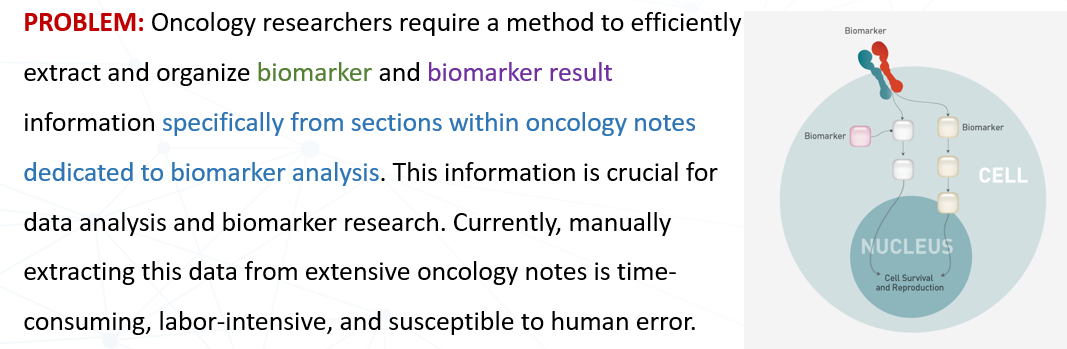

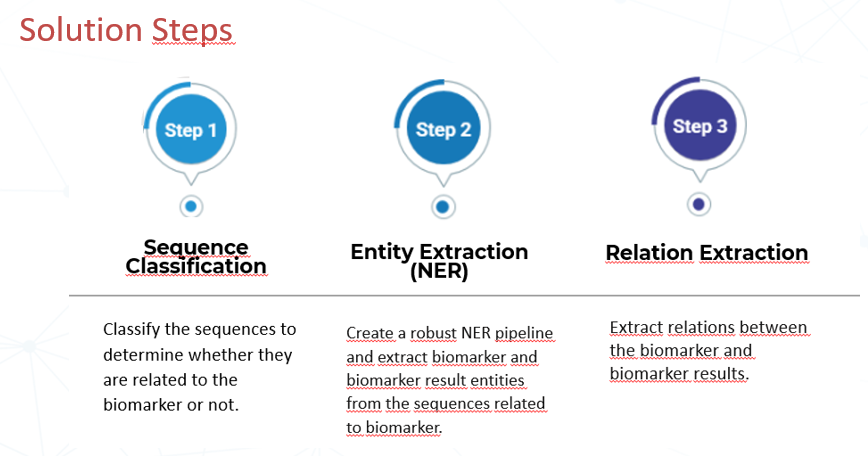

## 📌 All-In-One Pipeline

🎯 If we run the NER pipeline to extract Biomarker-Biomarker_Result entities first, there may be false positives for Biomarker entities that are not mentioned in biomarker-related sections or sequences, particularly those with the same spelling as other words. Therefore, we will first classify the sentences to determine if they are related to biomarkers, then merge the related sentences and run the NER pipeline on them. Afterward, we will check the relationships of the entities extracted from the biomarker-related sections.

🎯 We will create an all-in-one pipeline to perform all these steps simultaneously.

In [ ]:
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence_detector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(['sentence']) \
    .setOutputCol('token')

sequenceClassifier = MedicalBertForSequenceClassification.pretrained("bert_sequence_classifier_biomarker","en","clinical/models")\
    .setInputCols(["sentence",'token'])\
    .setOutputCol("prediction")

document_filterer = DocumentFiltererByClassifier()\
    .setInputCols(["sentence", "prediction"])\
    .setOutputCol("filtered_documents")\
    .setWhiteList(["1"])

word_embeddings = WordEmbeddingsModel().pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["filtered_documents", "token"]) \
    .setOutputCol("embeddings")

biomarker_ner = MedicalNerModel.pretrained("ner_oncology_biomarker", "en", "clinical/models") \
    .setInputCols(["filtered_documents", "token", "embeddings"]) \
    .setOutputCol("biomarker_ner")

biomarker_ner_converter = NerConverterInternal() \
    .setInputCols(["filtered_documents", "token", "biomarker_ner"]) \
    .setOutputCol("biomarker_chunk")

pos_tagger = PerceptronModel.pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["filtered_documents", "token"]) \
    .setOutputCol("pos_tags")

dependency_parser = DependencyParserModel.pretrained("dependency_conllu", "en") \
    .setInputCols(["filtered_documents", "pos_tags", "token"]) \
    .setOutputCol("dependencies")

biomarker_re_model = RelationExtractionModel.pretrained("re_oncology_biomarker_result", "en", "clinical/models") \
    .setInputCols(["embeddings", "pos_tags", "biomarker_chunk", "dependencies"]) \
    .setOutputCol("biomarker_relation") \
    .setRelationPairs(['Biomarker-Biomarker_Result']) \
    .setMaxSyntacticDistance(10)

biomarker_pipeline = Pipeline().setStages([
    document_assembler,
    sentence_detector,
    tokenizer,
    sequenceClassifier,
    document_filterer,
    word_embeddings,
    biomarker_ner,
    biomarker_ner_converter,
    pos_tagger,
    dependency_parser,
    biomarker_re_model
])

data = spark.createDataFrame([["""In the realm of cancer research, several biomarkers have emerged as crucial indicators of disease progression and treatment response.
For instance, the expression levels of HER2/neu, a protein receptor, have been linked to aggressive forms of breast cancer.
Additionally, the presence of prostate-specific antigen (PSA) is often monitored to track the progression of prostate cancer.
Moreover, in cardiovascular health, high-sensitivity C-reactive protein (hs-CRP) serves as a biomarker for inflammation and potential risk of heart disease.
Meanwhile, elevated levels of troponin T are indicative of myocardial damage, commonly observed in acute coronary syndrome.
In the field of diabetes management, glycated hemoglobin is a widely used to assess long-term blood sugar control.
Its levels reflect the average blood glucose concentration over the past two to three months, offering valuable insights into disease management strategies.
Immunohistochemistry was negative for thyroid transcription factor-1 and napsin A.
The test was positive for ER and PR, and negative for HER2."""]]).toDF("text")

biomarker_model = biomarker_pipeline.fit(data)
biomarker_result = biomarker_model.transform(data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
bert_sequence_classifier_biomarker download started this may take some time.
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_oncology_biomarker download started this may take some time.
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]
re_oncology_biomarker_result download started this may take some time.
[OK!]


In [ ]:
biomarker_result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          prediction|  filtered_documents|          embeddings|       biomarker_ner|     biomarker_chunk|            pos_tags|        dependencies|  biomarker_relation|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|In the realm of c...|[{document, 0, 10...|[{document, 0, 13...|[{token, 0, 1, In...|[{category, 0, 13...|[{document, 134, ...|[{word_embeddings...|[{named_entity, 1...|[{chunk, 173, 180...|[{pos, 134, 136, ...|[{dependency, 134...|[{cate

In [ ]:
import pyspark.sql.functions as F

biomarker_result.select(F.explode(F.arrays_zip(biomarker_result.sentence.result,
                                               biomarker_result.sentence.metadata,
                                               biomarker_result.prediction.result
                                              )).alias("cols")) \
                .select(F.expr("cols['1']['sentence']").alias("sentence_id"),
                        F.expr("cols['0']").alias("sentences"),
                        F.expr("cols['2']").alias("classes")
                        ).show(truncate=False)

+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|sentence_id|sentences                                                                                                                                                   |classes|
+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|0          |In the realm of cancer research, several biomarkers have emerged as crucial indicators of disease progression and treatment response.                       |0      |
|1          |For instance, the expression levels of HER2/neu, a protein receptor, have been linked to aggressive forms of breast cancer.                                 |1      |
|2          |Additionally, the presence of prostate-specific antigen (PSA) is often monitored to track th

In [ ]:
biomarker_result.select(F.explode(F.arrays_zip(biomarker_result.filtered_documents.result,
                                               biomarker_result.filtered_documents.metadata
                                              )).alias("cols")) \
                .select(F.expr("cols['1']['sentence']").alias("sentence_id"),
                        F.expr("cols['0']").alias("sentence"),
                        F.expr("cols['1']['class_label']").alias("class_label")
                       ).show(truncate=False)

+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|sentence_id|sentence                                                                                                                                                    |class_label|
+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|1          |For instance, the expression levels of HER2/neu, a protein receptor, have been linked to aggressive forms of breast cancer.                                 |1          |
|2          |Additionally, the presence of prostate-specific antigen (PSA) is often monitored to track the progression of prostate cancer.                               |1          |
|3          |Moreover, in cardiovascular health, high-sensitivity C-reactive protein 

In [ ]:
biomarker_result.select(F.explode(F.arrays_zip(biomarker_result.biomarker_chunk.result,
                                               biomarker_result.biomarker_chunk.begin,
                                               biomarker_result.biomarker_chunk.end,
                                               biomarker_result.biomarker_chunk.metadata,
                                              )).alias("cols")) \
                .select(F.expr("cols['1']").alias("begin"),
                        F.expr("cols['2']").alias("end"),
                        F.expr("cols['0']").alias("chunk"),
                        F.expr("cols['3']['entity']").alias("ner_label")
                       ).show(truncate=False)

+-----+----+------------------------------+----------------+
|begin|end |chunk                         |ner_label       |
+-----+----+------------------------------+----------------+
|173  |180 |HER2/neu                      |Biomarker       |
|185  |200 |protein receptor              |Biomarker       |
|288  |312 |prostate-specific antigen     |Biomarker       |
|315  |317 |PSA                           |Biomarker       |
|962  |969 |negative                      |Biomarker_Result|
|975  |1004|thyroid transcription factor-1|Biomarker       |
|1010 |1017|napsin A                      |Biomarker       |
|1033 |1040|positive                      |Biomarker_Result|
|1046 |1047|ER                            |Biomarker       |
|1053 |1054|PR                            |Biomarker       |
|1061 |1068|negative                      |Biomarker_Result|
|1074 |1077|HER2                          |Biomarker       |
+-----+----+------------------------------+----------------+



In [ ]:
biomarker_result_df = biomarker_result.select(F.explode(F.arrays_zip(biomarker_result.biomarker_relation.result,
                                                                     biomarker_result.biomarker_relation.metadata,
                                                                    )).alias("cols")) \
                                      .select(F.expr("cols['0']").alias("relations"),\
                                              F.expr("cols['1']['entity1_begin']").alias("entity1_begin"),\
                                              F.expr("cols['1']['entity1_end']").alias("entity1_end"),\
                                              F.expr("cols['1']['chunk1']" ).alias("chunk1" ),\
                                              F.expr("cols['1']['entity1']").alias("entity1"),\
                                              F.expr("cols['1']['entity2_begin']").alias("entity2_begin"),\
                                              F.expr("cols['1']['entity2_end']").alias("entity2_end"),\
                                              F.expr("cols['1']['chunk2']" ).alias("chunk2" ),\
                                              F.expr("cols['1']['entity2']").alias("entity2")
                                             ).toPandas()

biomarker_result_df

,relations,entity1_begin,entity1_end,chunk1,entity1,entity2_begin,entity2_end,chunk2,entity2
0,is_finding_of,962,969,negative,Biomarker_Result,975,1004,thyroid transcription factor-1,Biomarker
1,is_finding_of,962,969,negative,Biomarker_Result,1010,1017,napsin A,Biomarker
2,is_finding_of,1033,1040,positive,Biomarker_Result,1046,1047,ER,Biomarker
3,is_finding_of,1033,1040,positive,Biomarker_Result,1053,1054,PR,Biomarker
4,O,1033,1040,positive,Biomarker_Result,1074,1077,HER2,Biomarker
5,O,1046,1047,ER,Biomarker,1061,1068,negative,Biomarker_Result
6,O,1053,1054,PR,Biomarker,1061,1068,negative,Biomarker_Result
7,is_finding_of,1061,1068,negative,Biomarker_Result,1074,1077,HER2,Biomarker


🎊  Let's filter the relation results with the entities in a relation and have the final `biomarker-biomarker_result` table from the related sections of the clinical text.

In [ ]:
biomarker_result_df = biomarker_result_df[biomarker_result_df.relations != "O"].reset_index(drop=True)
biomarker_result_df

,relations,entity1_begin,entity1_end,chunk1,entity1,entity2_begin,entity2_end,chunk2,entity2
0,is_finding_of,962,969,negative,Biomarker_Result,975,1004,thyroid transcription factor-1,Biomarker
1,is_finding_of,962,969,negative,Biomarker_Result,1010,1017,napsin A,Biomarker
2,is_finding_of,1033,1040,positive,Biomarker_Result,1046,1047,ER,Biomarker
3,is_finding_of,1033,1040,positive,Biomarker_Result,1053,1054,PR,Biomarker
4,is_finding_of,1061,1068,negative,Biomarker_Result,1074,1077,HER2,Biomarker


# LLM & QA & Summarization


In this section, we will pose a series of questions about the clinical notes to extract summaries and obtain valuable insights and answers.

In [7]:
sample_text = mt_samples_df.limit(1).collect()[0]['text']
print(sample_text)

Sample Type / Medical Specialty:
Hematology - Oncology
Sample Name:
Discharge Summary - Mesothelioma - 1
Description:
Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
(Medical Transcription Sample Report)
PRINCIPAL DIAGNOSIS:
Mesothelioma.
SECONDARY DIAGNOSES:
Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
PROCEDURES
1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy.
2. On August 20, 2007, thoracentesis.
3. On August 31, 2007, Port-A-Cath placement.
HISTORY AND PHYSICAL:
The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care cen

In [8]:
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

medical_llm = MedicalLLM.pretrained("jsl_medm_q8_v1", "en", "clinical/models")\
    .setInputCols("document")\
    .setOutputCol("completions")\
    .setBatchSize(1)\
    .setNPredict(100)\
    .setUseChatTemplate(True)\
    .setTemperature(0)

llm_pipeline = Pipeline(
    stages = [
        document_assembler,
        medical_llm
])

jsl_medm_q8_v1 download started this may take some time.
[OK!]


In [9]:
%%time
medm_prompt = """
### Question:
Summarize the patient's relevant medical history, including past procedures and conditions.
""" + sample_text

data = spark.createDataFrame([[medm_prompt]]).toDF("text")

results = llm_pipeline.fit(data).transform(data).cache()
response = results.select("completions").collect()[0].completions[0].result
print(response)

The patient has a history of mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and deep venous thrombosis.
CPU times: user 218 ms, sys: 46.3 ms, total: 264 ms
Wall time: 39.2 s


In [10]:
medm_prompt = """
### Question:
What stage of mesothelioma does the patient have, and what evidence supports this staging?
""" + sample_text

data = spark.createDataFrame([[medm_prompt]]).toDF("text")

results = llm_pipeline.fit(data).transform(data).cache()
response = results.select("completions").collect()[0].completions[0].result
print(response)

Based on the provided information, the patient has stage III mesothelioma.


In [11]:
medm_prompt = """
### Question:
Based on the clinical note what procedures were performed on the patient, and what were the outcomes?
""" + sample_text

data = spark.createDataFrame([[medm_prompt]]).toDF("text")

results = llm_pipeline.fit(data).transform(data).cache()
response = results.select("completions").collect()[0].completions[0].result
print(response)

Based on the clinical note, the procedures performed on the patient were:

1. Decortication of the lung with pleural biopsy and transpleural fluoroscopy on August 24, 2007.
2. Thoracentesis on August 20, 2007.
3. Port-A-Cath placement on August 31, 2007.

The outcomes of these procedures are not explicitly stated in the clinical note, but it is mentioned that the patient was discharged the following day after discontin


In [12]:
medm_prompt = """
### Question:
Summarize the hospital course of the patient.
""" + sample_text

data = spark.createDataFrame([[medm_prompt]]).toDF("text")

results = llm_pipeline.fit(data).transform(data).cache()
response = results.select("completions").collect()[0].completions[0].result
print(response)

The patient is a 41-year-old Vietnamese female who was admitted to the hospital for a right-sided pleural effusion. She has a history of pericarditis and pericardectomy in May 2006, and was found to have bilateral pleural effusions on a CT scan prior to her pericardectomy. She was diagnosed with mesothelioma and underwent thoracoscopy with fluid biopsies, which revealed epithelioid malignant mesothelioma. She was started


# Zero Shot Oncology NER Model

Zero-shot Named Entity Recognition (NER) enables the identification of entities in text with minimal effort. By leveraging pre-trained language models and contextual understanding, zero-shot NER extends entity recognition capabilities to new domains and languages. While the model card includes default labels as examples, it is important to highlight that users are not limited to these labels.

**The model is designed to support any set of entity labels, allowing users to adapt it to their specific use cases. For best results, it is recommended to use labels that are conceptually similar to the provided defaults.**

Now lets extract entities from the summarization of the hospital course of the patient.

In [13]:
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence_detector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

labels = ["Adenopathy", "Age","Biomarker","Biomarker_Result","Body_Part","Cancer_Dx","Cancer_Surgery",
        "Cycle_Count","Cycle_Day","Date","Death_Entit","Directio","Dosage","Duration","Frequency",
        "Gender","Grade","Histological_Type","Imaging_Test","Invasion","Metastasis","Oncogene","Pathology_Test",
        "Race_Ethnicity","Radiation_Dose","Relative_Date","Response_To_Treatment","Route","Smoking_Status",
        "Staging","Therapy","Tumor_Finding","Tumor_Size"]

pretrained_zero_shot_ner = PretrainedZeroShotNER().pretrained("zeroshot_ner_oncology_medium", "en", "clinical/models")\
    .setInputCols("sentence", "token")\
    .setOutputCol("ner")\
    .setPredictionThreshold(0.5)\
    .setLabels(labels)

ner_converter = NerConverterInternal()\
    .setInputCols("sentence", "token", "ner")\
    .setOutputCol("ner_chunk")


ner_zs_pipeline = Pipeline().setStages([
    document_assembler,
    sentence_detector,
    tokenizer,
    pretrained_zero_shot_ner,
    ner_converter
])

data = spark.createDataFrame([[response]]).toDF("text")

ner_results = ner_zs_pipeline.fit(data).transform(data)

zeroshot_ner_oncology_medium download started this may take some time.
[OK!]


In [14]:
from pyspark.sql import functions as F

ner_res_df = ner_results.select(F.explode(F.arrays_zip(ner_results.ner_chunk.result,
                                                       ner_results.ner_chunk.metadata)).alias("cols")) \
                        .select(F.expr("cols['0']").alias("chunk"),
                                F.expr("cols['1']['entity']").alias("ner_label"))

ner_res_df.show(50,truncate=False)

+--------------+-----------------+
|chunk         |ner_label        |
+--------------+-----------------+
|41-year-old   |Age              |
|Vietnamese    |Race_Ethnicity   |
|female        |Gender           |
|pleural       |Body_Part        |
|She           |Gender           |
|pericarditis  |Body_Part        |
|pericardectomy|Cancer_Surgery   |
|May 2006      |Date             |
|pleural       |Body_Part        |
|CT scan       |Imaging_Test     |
|her           |Gender           |
|pericardectomy|Cancer_Surgery   |
|She           |Gender           |
|mesothelioma  |Adenopathy       |
|thoracoscopy  |Imaging_Test     |
|fluid biopsies|Pathology_Test   |
|epithelioid   |Histological_Type|
|mesothelioma  |Adenopathy       |
|She           |Gender           |
+--------------+-----------------+

